In [1]:
import sys

sys.path.append("/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/src")

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import data
from pathlib import Path

### Loading and pre-processing clean

In [3]:
canary_type = "clean"

In [4]:
# Data
data_generator = data.DatasetGenerator(
    num_shadow=64,
    num_canaries=500,
    canary_type=data.CanaryType(canary_type),
    num_poison=0,
    poison_type=data.PoisonType.CANARY_DUPLICATES,
    data_dir=Path("/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/data"),
    seed=0,
    download=False,
)

(
    attack_ys,
    shadow_membership_mask,
    canary_indices,
) = data_generator.build_attack_data()

In [5]:
# Canary indices
canary_membership = torch.zeros(500, 64).to(dtype=bool)
canary_indices_per_shadow = {}
psmi_mean = torch.zeros(500, 64)
losses = torch.zeros(500, 64)
logit_gaps = torch.zeros(500, 64)

for shadow_idx in range(64):
    canary_membership[:,shadow_idx] = shadow_membership_mask[canary_indices, shadow_idx]
    canary_indices_per_shadow[shadow_idx] = canary_indices[shadow_membership_mask[canary_indices, shadow_idx]]
    psmi_mean[:,shadow_idx] = torch.tensor(torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/shadow/{shadow_idx}/psmi.pt")[canary_indices], dtype=float)
    losses[:,shadow_idx] = torch.tensor(torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/shadow/{shadow_idx}/losses.pt")[canary_indices], dtype=float)
    logit_gaps[:,shadow_idx] = torch.tensor(torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/shadow/{shadow_idx}/logit_gaps.pt")[canary_indices], dtype=float)

In [6]:
attack_scores: torch.Tensor = torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/attack_scores_lira_da_hinge.pt")
attack_membership: torch.Tensor = torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/attack_membership_lira_da_hinge.pt")

attack_scores = attack_scores.view(64,500).T
attack_membership = attack_membership.view(64,500).T

In [7]:
print(f"attack_membership: {attack_membership.size()}")
print(f"canary_membership: {canary_membership.size()}")
print(f"Are equal? {torch.sum(attack_membership == canary_membership).item() == 32000}")

attack_membership: torch.Size([500, 64])
canary_membership: torch.Size([500, 64])
Are equal? True


### Loading and pre-processing OOD

In [8]:
canary_type = "ood"

In [9]:
# Data
data_generator = data.DatasetGenerator(
    num_shadow=64,
    num_canaries=500,
    canary_type=data.CanaryType(canary_type),
    num_poison=0,
    poison_type=data.PoisonType.CANARY_DUPLICATES,
    data_dir=Path("/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/data"),
    seed=0,
    download=False,
)

(
    attack_ys,
    shadow_membership_mask,
    canary_indices,
) = data_generator.build_attack_data()

In [10]:
# Canary indices
psmi_full_ood = torch.zeros(50000, 64)
losses_full_ood = torch.zeros(50000, 64)
logit_gaps_full_ood = torch.zeros(50000, 64)

for shadow_idx in range(64):
    psmi_full_ood[:,shadow_idx] = torch.tensor(torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/shadow/{shadow_idx}/psmi.pt"), dtype=float)
    losses_full_ood[:,shadow_idx] = torch.tensor(torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/shadow/{shadow_idx}/losses.pt"), dtype=float)
    logit_gaps_full_ood[:,shadow_idx] = torch.tensor(torch.load(f"/Users/jeremie/Documents/01-Travail/01-Doctorat/adaptive-defense/experiments/adadef/iclr_{canary_type}/shadow/{shadow_idx}/logit_gaps.pt"), dtype=float)

In [11]:
is_canary = torch.zeros(50000).to(dtype=bool)
is_canary[canary_indices] = True

In [12]:
flat_is_ood = []
flat_psmi_ood = []
flat_loss_ood = []
flat_logit_gaps_ood = []

for shadow_idx in tqdm(range(3)):
    is_not_nan = ~np.isnan(psmi_full_ood[:,shadow_idx]).to(dtype=bool)
    flat_is_ood.extend(is_canary[is_not_nan])
    flat_psmi_ood.extend(psmi_full_ood[:,shadow_idx][is_not_nan])
    flat_loss_ood.extend(losses_full_ood[:,shadow_idx][is_not_nan])
    flat_logit_gaps_ood.extend(logit_gaps_full_ood[:,shadow_idx][is_not_nan])

100%|██████████| 3/3 [00:00<00:00,  6.50it/s]


In [13]:
flat_psmi_ood_reversed = [-item for item in flat_psmi_ood]
flat_logit_gaps_ood_reversed = [-item for item in flat_logit_gaps_ood]

## CIFAR-10 main figures

In [14]:
COLORS = ['#165c8c', '#ffb26e', '#2ca02c']

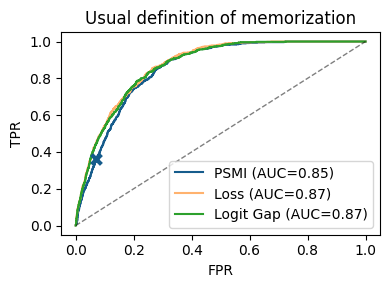

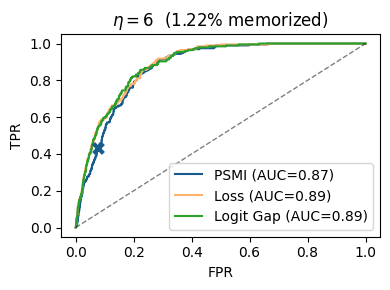

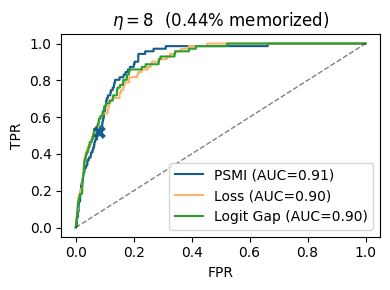

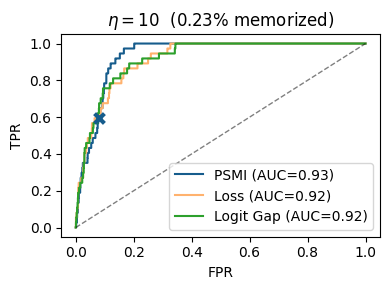

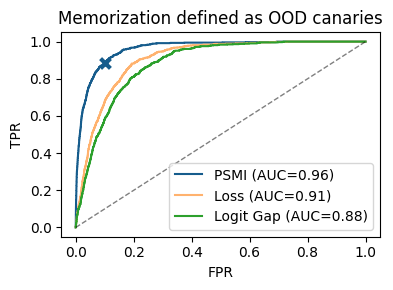

In [15]:
# Plotting
local_thds = [4, 6, 8, 10]
n_rows = 1
n_cols = 1
prop_markevery = 0.25


for idx_col, local_threshold in enumerate(local_thds):

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

    is_memorized = attack_scores >= local_threshold # Shape (500, 64)

    # Filtering elements that were present during training
    flat_is_memorized = []
    flat_psmi = []
    flat_loss = []
    flat_logit_gaps = []

    for shadow_idx in range(64):

        flat_is_memorized.extend(is_memorized[canary_membership[:,shadow_idx],shadow_idx])
        flat_psmi.extend(psmi_mean[canary_membership[:,shadow_idx],shadow_idx])
        flat_loss.extend(losses[canary_membership[:,shadow_idx],shadow_idx])
        flat_logit_gaps.extend(logit_gaps[canary_membership[:,shadow_idx],shadow_idx])

    # Reversing PSMI
    flat_psmi_reversed = [-item for item in flat_psmi]
    flat_logit_gaps_reversed = [-item for item in flat_logit_gaps]

    prop_memo = (sum(flat_is_memorized) / len(flat_is_memorized)).item()

    # PSMI
    fpr, tpr, thd = roc_curve(flat_is_memorized, flat_psmi_reversed, drop_intermediate=False)
    psmi_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"PSMI (AUC={psmi_auc:.2f})", color=COLORS[0])

    # Default PSMI
    for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
        if final_thd < 0:
            break
    ax.scatter(final_fpr, final_tpr, marker="x", label=None, s=50, linewidths=3, zorder=10, color=COLORS[0])

    # Loss
    fpr, tpr, thd = roc_curve(flat_is_memorized, flat_loss, drop_intermediate=False)
    loss_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"Loss (AUC={loss_auc:.2f})", color=COLORS[1])

    # Logit Gap
    fpr, tpr, thd = roc_curve(flat_is_memorized, flat_logit_gaps_reversed, drop_intermediate=False)
    logit_gap_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"Logit Gap (AUC={logit_gap_auc:.2f})", color=COLORS[2])

    # Plot details
    ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=.5)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(r"$\eta = $" + f"{local_threshold}  ({prop_memo:.2%} memorized)")
    ax.legend()

    fig.tight_layout()
    fig.savefig(f"ablation_cifar-10_loglira_{local_threshold}.pdf")

    if local_threshold == 4:
        ax.set_title("Usual definition of memorization")
        fig.savefig(f"ablation_cifar-10_loglira_4_main.pdf")

# ================= Canaries ===================
    
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

# PSMI
fpr, tpr, thd = roc_curve(flat_is_ood, flat_psmi_ood_reversed, drop_intermediate=False)
psmi_ood_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label=f"PSMI (AUC={psmi_ood_auc:.2f})", color=COLORS[0])

# Default PSMI
for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
    if final_thd < 0:
        break
ax.scatter(final_fpr, final_tpr, marker="x", label=None, s=50, linewidths=3, zorder=10, color=COLORS[0])

# Loss
fpr, tpr, thd = roc_curve(flat_is_ood, flat_loss_ood, drop_intermediate=False)
loss_ood_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label=f"Loss (AUC={loss_ood_auc:.2f})", color=COLORS[1])

# Logit Gap
fpr, tpr, thd = roc_curve(flat_is_ood, flat_logit_gaps_ood_reversed, drop_intermediate=False)
logit_gaps_ood_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label=f"Logit Gap (AUC={logit_gaps_ood_auc:.2f})", color=COLORS[2])

# Plot details
ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=.5)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("Canaries")
ax.legend()

fig.tight_layout()
fig.savefig(f"ablation_cifar-10_canaries.pdf")

ax.set_title("Memorization defined as OOD canaries")
fig.savefig(f"ablation_cifar-10_canaries_main.pdf")

## Perf evolution - version with LiRA thresholds

In [16]:
memo_thresholds = np.linspace(1, 10, endpoint=True, num=50)
psmi_auc_list = []
loss_auc_list = []
logit_gap_auc_list = []
prop_memo = []

for memo_thd in memo_thresholds:
    is_memorized = attack_scores >= memo_thd # Shape (500, 64)

    # Filtering elements that were present during training
    flat_is_memorized = []
    flat_psmi = []
    flat_loss = []
    flat_logit_gaps = []

    for shadow_idx in range(64):

        flat_is_memorized.extend(is_memorized[canary_membership[:,shadow_idx],shadow_idx])
        flat_psmi.extend(psmi_mean[canary_membership[:,shadow_idx],shadow_idx])
        flat_loss.extend(losses[canary_membership[:,shadow_idx],shadow_idx])
        flat_logit_gaps.extend(logit_gaps[canary_membership[:,shadow_idx],shadow_idx])

    # Reversing PSMI
    flat_psmi_reversed = [-item for item in flat_psmi]
    flat_logit_gaps_reversed = [-item for item in flat_logit_gaps]

    # PSMI
    fpr, tpr, thd = roc_curve(flat_is_memorized, flat_psmi_reversed, drop_intermediate=False)
    psmi_auc_list.append(auc(fpr, tpr))

    # Loss
    fpr, tpr, thd = roc_curve(flat_is_memorized, flat_loss, drop_intermediate=False)
    loss_auc_list.append(auc(fpr, tpr))

    # Logit Gap
    fpr, tpr, thd = roc_curve(flat_is_memorized, flat_logit_gaps_reversed, drop_intermediate=False)
    logit_gap_auc_list.append(auc(fpr, tpr))

    # Prop memo
    prop_memo.append(sum(flat_is_memorized) / len(flat_is_memorized))


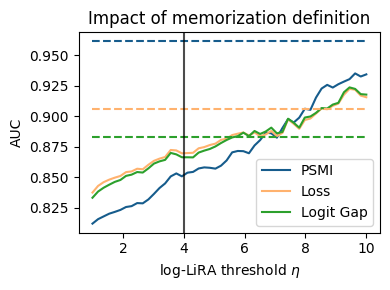

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
# ax_prop = ax.twinx()

ax.plot(memo_thresholds, psmi_auc_list, label="PSMI", color=COLORS[0])
ax.plot(memo_thresholds, loss_auc_list, label="Loss", color=COLORS[1])
ax.plot(memo_thresholds, logit_gap_auc_list, label="Logit Gap", color=COLORS[2])

ax.plot(memo_thresholds, [psmi_ood_auc for _ in memo_thresholds], color=COLORS[0], linestyle="--")
ax.plot(memo_thresholds, [loss_ood_auc for _ in memo_thresholds], color=COLORS[1], linestyle="--")
ax.plot(memo_thresholds, [logit_gaps_ood_auc for _ in memo_thresholds], color=COLORS[2], linestyle="--")

# ax_prop.plot(memo_thresholds, prop_memo, color=COLORS[3])
# Fake for legend
# ax.plot(memo_thresholds, logit_gap_auc_list, label="Prop memo", color=COLORS[3], zorder=-1)

ax.axvline(4, label=None, color="black", alpha=.7)

# ax.set_xscale("log")
ax.set_xlabel(r"log-LiRA threshold $\eta$")
ax.set_ylabel("AUC")
# ax_prop.set_ylabel("Proportion memorized")
ax.set_title(f"Impact of memorization definition")
ax.legend()

fig.tight_layout()
fig.savefig("ablation_cifar-10_eta.pdf")